In [1]:
import time
import ROOT
import math
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from root_pandas import read_root
from __future__ import division
from statsmodels.stats.proportion import proportion_confint
%run functions.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [2]:
def getDataMatched(inputFiles):
    cols = []
    scalar = []
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    cols.append('matched_truthPhi')
    cols.append('phi')

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
file1 = ["$HOME/EIC/output/allsi/629.root"]

In [5]:
a = getDataMatched(file1)


Processed $HOME/EIC/output/allsi/629.root in 12.0 seconds


In [6]:
def drop(df): # drop rows with duplicated "matched" jets
    row_dup = []
    for i in range(0, len(df)):
        match = np.asarray(df['matched_truthPhi'])[i]
        if i < len(df)-20:
            end = i + 21
        else:
            end = len(df)
        for j in range(i+1, end):
            match2 = np.asarray(df['matched_truthPhi'])[j]
            if match == match2:
                #print df.loc[[i]]
                #print df.loc[[j]]
                row_dup.append(i)
    #print row_dup
    print len(row_dup), "pairs of duplicated all truth jets found"
    df0 = df.drop(row_dup)
    return df0

In [7]:
a0 = drop(a)

92938 pairs of duplicated all truth jets found


In [8]:
a1 = applyCut(a0, 'njets == 1', 'njets = 1')

njets = 1 418959  fraction kept: 12.8


In [9]:
a1.eval('dphi = phi - electron_truthPhi - 3.1415926535', inplace=True)
a1.eval('truth_dphi = matched_truthPhi - electron_truthPhi - 3.1415926535', inplace=True)

In [10]:
def fix_dphi(df, var='dphi'):
    b = (df.loc[df[var] < (-1) * np.pi]).index
    for i in range(0,len(b)):
        df.at[b[i], var] = 6.28318530718 + df.at[b[i], var]
    df_new = df.eval('abs_' + var + '= abs(' + var + ')')    
    print 'Fixed ' + var + ' delta phi range'
    return df_new

In [11]:
a2 = fix_dphi(a1)
a3 = fix_dphi(a2, var = 'truth_dphi')

Fixed dphi delta phi range
Fixed truth_dphi delta phi range


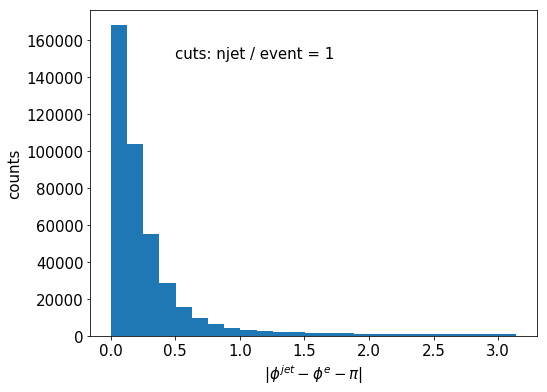

In [12]:
fig = plt.figure(figsize=(8,6))
plt.hist(a3['abs_dphi'], bins=25)
plt.xlabel('$|\phi^{jet}- \phi^e - \pi|$', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.5, 150000, 'cuts: njet / event = 1', fontsize = 15)
plt.savefig('images/dphi.png', bbox_inches='tight')

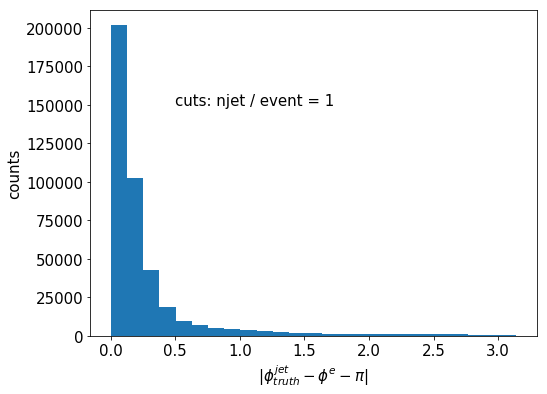

In [13]:
fig = plt.figure(figsize=(8,6))
plt.hist(a3['abs_truth_dphi'], bins=25)
plt.xlabel('$|\phi^{jet}_{truth}- \phi^e - \pi|$', fontsize=15)
plt.ylabel('counts', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(0.5, 150000, 'cuts: njet / event = 1', fontsize = 15)
plt.savefig('images/truth_dphi.png', bbox_inches='tight')